<a href="https://colab.research.google.com/github/Z4HRA-S/Solar_Panel_Object_Detection/blob/main/segmentation_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Read the Data

In [ ]:
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import torchvision.transforms.functional as TF

In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/proactive

/content/drive/MyDrive/Colab Notebooks/proactive


In [ ]:
data_path="processed_data/"
data_dir=listdir(data_path)

In [ ]:
data = [TF.to_tensor(
      Image.open(data_path+img)
      ) for img in data_dir if img[-8:]!="mask.bmp"]

In [ ]:
masks = [TF.to_tensor(TF.to_grayscale(
      Image.open(data_path+img)
      )) for img in data_dir if img[-8:]=="mask.bmp"]

In [ ]:
import matplotlib.patches as patches

def plot(image,label,box=None):
  image = image.transpose(0,2).transpose(0,1).detach().numpy()
  label = label.squeeze().detach().numpy()
  i, (im1) = plt.subplots(1,2)
  i.set_figwidth(5)
  im1[0].imshow(image)
  if box is not None:
    rect = patches.Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=1, edgecolor='r', facecolor='none')
    im1[0].add_patch(rect)

  im1[1].imshow(label)

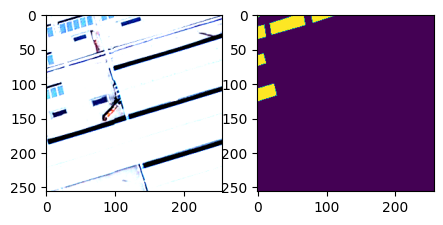

In [ ]:
plot(data[30],masks[30])

#Model Training

## Semantic Segmentation with U-Net

In [ ]:
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torchvision.transforms import CenterCrop
from torch.nn import functional as F
import torch

In [ ]:
# for this cell I copied the code from https://pyimagesearch.com/2021/11/08/u-net-training-image-segmentation-models-in-pytorch/

class Block(Module):
	def __init__(self, inChannels, outChannels):
		super().__init__()
		self.conv1 = Conv2d(inChannels, outChannels, 3)
		self.relu = ReLU()
		self.conv2 = Conv2d(outChannels, outChannels, 3)
	def forward(self, x):
		return self.conv2(self.relu(self.conv1(x)))


class Encoder(Module):
	def __init__(self, channels):
		super().__init__()
		self.encBlocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
		self.pool = MaxPool2d(2)
	def forward(self, x):
		blockOutputs = []
		for block in self.encBlocks:
			x = block(x)
			blockOutputs.append(x)
			x = self.pool(x)
		return blockOutputs

class Decoder(Module):
	def __init__(self, channels=(64, 32, 16)):
		super().__init__()
		self.channels = channels
		self.upconvs = ModuleList(
			[ConvTranspose2d(channels[i], channels[i + 1], 2, 2)
			 	for i in range(len(channels) - 1)])
		self.dec_blocks = ModuleList(
			[Block(channels[i], channels[i + 1])
			 	for i in range(len(channels) - 1)])
	def forward(self, x, encFeatures):
		for i in range(len(self.channels) - 1):
			x = self.upconvs[i](x)
			encFeat = self.crop(encFeatures[i], x)
			x = torch.cat([x, encFeat], dim=1)
			x = self.dec_blocks[i](x)
		return x
	def crop(self, encFeatures, x):
		(_, _, H, W) = x.shape
		encFeatures = CenterCrop([H, W])(encFeatures)
		return encFeatures


class UNet(Module):
	def __init__(self, encChannels=(1, 16, 32, 64),
		 decChannels=(64, 32, 16),
		 nbClasses=1, retainDim=True,
		 outSize=(256,  256)):
		super().__init__()
		self.encoder = Encoder(encChannels)
		self.decoder = Decoder(decChannels)
		self.head = Conv2d(decChannels[-1], nbClasses, 1)
		self.retainDim = retainDim
		self.outSize = outSize
	def forward(self, x):
		encFeatures = self.encoder(x)
		decFeatures = self.decoder(encFeatures[::-1][0],
			encFeatures[::-1][1:])
		map = self.head(decFeatures)
		if self.retainDim:
			map = F.interpolate(map, self.outSize)
		return map

In [ ]:
from torchsummary import summary
model = UNet(encChannels=(3, 16, 32, 64))
#model.to("cuda:0")
summary(model,(3,256,256),device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
              ReLU-2         [-1, 16, 254, 254]               0
            Conv2d-3         [-1, 16, 252, 252]           2,320
             Block-4         [-1, 16, 252, 252]               0
         MaxPool2d-5         [-1, 16, 126, 126]               0
            Conv2d-6         [-1, 32, 124, 124]           4,640
              ReLU-7         [-1, 32, 124, 124]               0
            Conv2d-8         [-1, 32, 122, 122]           9,248
             Block-9         [-1, 32, 122, 122]               0
        MaxPool2d-10           [-1, 32, 61, 61]               0
           Conv2d-11           [-1, 64, 59, 59]          18,496
             ReLU-12           [-1, 64, 59, 59]               0
           Conv2d-13           [-1, 64, 57, 57]          36,928
            Block-14           [-1, 64,

In [ ]:
lr=0.0005
epoch = 40
batch_size=64
len_train = 700
len_val= len(data)-len_train

In [ ]:
train_set, val_set = torch.utils.data.random_split(list(zip(data,masks)),[len_train, len_val])
data_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=batch_size,
                                          shuffle=True)

validation_data_loader = torch.utils.data.DataLoader(val_set,
                                          batch_size=batch_size,
                                          shuffle=True)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.RMSprop(model.parameters(),lr=lr, weight_decay=wd, momentum=momentum, foreach=True)

loss_func = torch.nn.BCEWithLogitsLoss()

In [ ]:
train_loss=[]
val_loss=[]
for e in range(epoch):
  total_loss=0
  print(f"Epoch {e} ")
  for batch, data in enumerate(data_loader):
    #data[0].to("cuda:0")
    #data[1].to("cuda:0")
    output = model(data[0])
    loss = loss_func(output, data[1])
    total_loss += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  total_loss/=round(len_train/batch_size)+1
  train_loss.append(total_loss)
  print(f"train_loss: {total_loss.item():>7f}",end=" | ")

  with torch.no_grad():
    model.eval()
    for data in validation_data_loader:
      output = model(data[0])
      loss = loss_func(output, data[1])
      print(f"val_loss: {loss.item():>7f}")
      print("="*50)
    val_loss.append(loss)
  if val_loss[-1] <= min(val_loss):
    model_state = model.state_dict()
    opt_state = optimizer.state_dict()

torch.save({'epoch': epoch,
            'model_state_dict': model_state,
            'optimizer_state_dict': opt_state,
            'loss': train_loss,
          }, "saved_model/seg_w.pt")

Epoch 0 
train_loss: 0.601642 | val_loss: 0.614706
Epoch 1 
train_loss: 0.527908 | val_loss: 0.527469
Epoch 2 
train_loss: 0.488848 | val_loss: 0.481720
Epoch 3 
train_loss: 0.455613 | val_loss: 0.439240
Epoch 4 
train_loss: 0.437270 | val_loss: 0.413654
Epoch 5 
train_loss: 0.418859 | val_loss: 0.385013
Epoch 6 
train_loss: 0.404605 | val_loss: 0.387516
Epoch 7 
train_loss: 0.399087 | val_loss: 0.372038
Epoch 8 
train_loss: 0.395579 | val_loss: 0.365628
Epoch 9 
train_loss: 0.389512 | val_loss: 0.357599
Epoch 10 
train_loss: 0.385539 | val_loss: 0.353200
Epoch 11 
train_loss: 0.376574 | val_loss: 0.353075
Epoch 12 
train_loss: 0.369203 | val_loss: 0.344777
Epoch 13 
train_loss: 0.366122 | val_loss: 0.362833
Epoch 14 
train_loss: 0.365251 | val_loss: 0.337600
Epoch 15 
train_loss: 0.360121 | val_loss: 0.336600
Epoch 16 
train_loss: 0.359881 | val_loss: 0.363407
Epoch 17 
train_loss: 0.359679 | val_loss: 0.336098
Epoch 18 
train_loss: 0.358218 | val_loss: 0.342546
Epoch 19 
train_loss: 

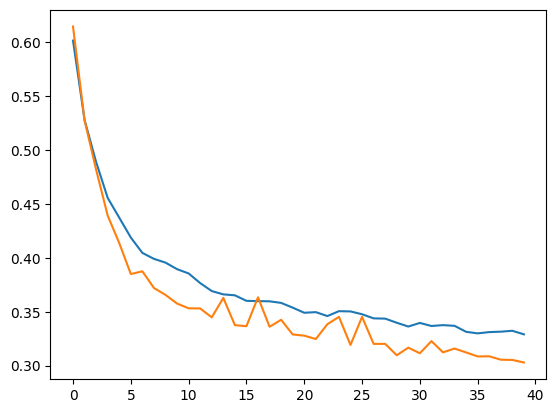

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(torch.stack(train_loss).detach().numpy(),label="train loss")
plt.plot(torch.stack(val_loss).detach().numpy(),label="validation loss")
plt.show()